# Factorial experiment without interaction

In [1]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

# Mock data
layout = jnp.hstack([jnp.repeat(0, 100), jnp.repeat(0, 100), jnp.repeat(1, 100), jnp.repeat(1, 100)])
background = jnp.hstack([jnp.repeat(0, 100), jnp.repeat(1, 100), jnp.repeat(0, 100), jnp.repeat(1, 100)])
success = jnp.repeat(0, 400)
success = success.at[0:5].set(1)
success = success.at[100:108].set(1)
success = success.at[200:205].set(1)
success = success.at[300:312].set(1)

In [2]:
invlogit = lambda x: 1 / (1 + jnp.exp(-x))

def model(f1, f2, obs=None):
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    b1 = numpyro.sample('b1', dist.Normal(0, 1).expand((2, )))
    b2 = numpyro.sample('b2', dist.Normal(0, 1).expand((2, )))

    y = numpyro.deterministic('y', b0 + b1[f1] + b2[f2])
    theta = numpyro.deterministic('theta', invlogit(y))

    o = numpyro.sample('o', dist.Bernoulli(theta), obs=obs)

In [3]:
mcmc = MCMC(NUTS(model=model), num_warmup=1000, num_samples=1000)
mcmc.run(random.PRNGKey(0), f1=layout, f2=background, obs=success)
mcmc.print_summary()

#            mean       std    median      5.0%     95.0%     n_eff     r_hat
#    b0     -1.27      0.67     -1.28     -2.35     -0.11    387.94      1.00
# b1[0]     -0.72      0.61     -0.73     -1.68      0.30    395.57      1.00
# b1[1]     -0.45      0.60     -0.49     -1.43      0.54    380.71      1.00
# b2[0]     -1.06      0.67     -1.05     -2.09      0.10    371.31      1.00
# b2[1]     -0.37      0.65     -0.39     -1.33      0.80    402.44      1.00

sample: 100%|██████████| 2000/2000 [00:02<00:00, 997.08it/s, 31 steps of size 1.80e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     -1.27      0.67     -1.28     -2.35     -0.11    387.94      1.00
     b1[0]     -0.72      0.61     -0.73     -1.68      0.30    395.57      1.00
     b1[1]     -0.45      0.60     -0.49     -1.43      0.54    380.71      1.00
     b2[0]     -1.06      0.67     -1.05     -2.09      0.10    371.31      1.00
     b2[1]     -0.37      0.65     -0.39     -1.33      0.80    402.44      1.00

Number of divergences: 0


In [4]:
predictive = Predictive(model, mcmc.get_samples(), return_sites=['theta'])
pred = predictive(random.PRNGKey(1), f1=jnp.array([0]), f2=jnp.array([0]))
jnp.mean(pred['theta'].T)
# Array(0.04790768, dtype=float32)

Array(0.04790768, dtype=float32)

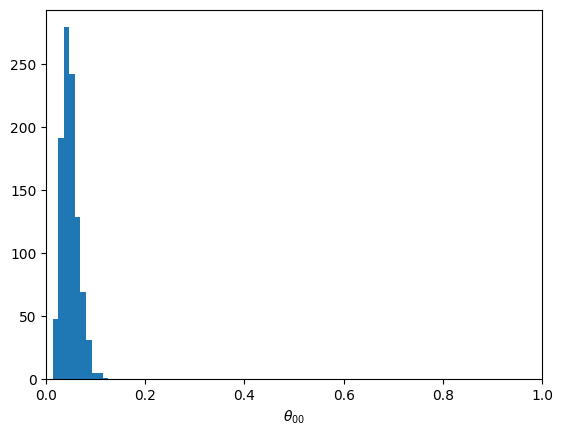

In [5]:
import matplotlib.pyplot as plt

plt.hist(pred['theta'].T)
plt.xlabel(r"$\theta_{00}$")
plt.xlim([0, 1])
plt.show()

In [6]:
# (grid, white) = (0, 0)
# (list, green) = (1, 1)
theta_00 = predictive(random.PRNGKey(1), f1=jnp.array([0]), f2=jnp.array([0]))['theta'].T
theta_11 = predictive(random.PRNGKey(1), f1=jnp.array([1]), f2=jnp.array([1]))['theta'].T

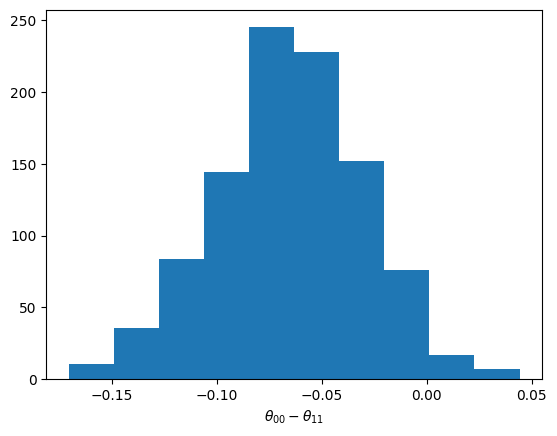

In [7]:
plt.hist(theta_00 - theta_11)
plt.xlabel(r"$\theta_{00} - \theta_{11}$")
plt.show()

# Factorial experiment with interaction

In [9]:
invlogit = lambda x: 1 / (1 + jnp.exp(-x))

def model(f1, f2, obs=None):
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    b1 = numpyro.sample('b1', dist.Normal(0, 1).expand((2, )))
    b2 = numpyro.sample('b2', dist.Normal(0, 1).expand((2, )))
    b12 = numpyro.sample('b12', dist.Normal(0, 1).expand((2, 2,)))

    y = numpyro.deterministic('y', b0 + b1[f1] + b2[f2] + b12[f1, f2])
    theta = numpyro.deterministic('theta', invlogit(y))

    o = numpyro.sample('o', dist.Bernoulli(theta), obs=obs)

In [10]:
mcmc = MCMC(NUTS(model=model), num_warmup=1000, num_samples=1000)
mcmc.run(random.PRNGKey(0), f1=layout, f2=background, obs=success)
mcmc.print_summary()

#               mean       std    median      5.0%     95.0%     n_eff     r_hat
#       b0     -1.16      0.76     -1.16     -2.28      0.19    826.89      1.00
#    b1[0]     -0.67      0.76     -0.65     -1.83      0.62    742.92      1.00
#    b1[1]     -0.52      0.75     -0.53     -1.68      0.69    683.44      1.00
# b12[0,0]     -0.35      0.79     -0.36     -1.56      1.05    697.73      1.00
# b12[0,1]     -0.27      0.78     -0.25     -1.46      1.02    829.00      1.00
# b12[1,0]     -0.48      0.81     -0.48     -1.82      0.84    777.18      1.00
# b12[1,1]      0.00      0.79     -0.04     -1.22      1.35    673.71      1.00
#    b2[0]     -0.78      0.75     -0.79     -1.93      0.53    680.60      1.00
#    b2[1]     -0.37      0.74     -0.39     -1.54      0.93    852.62      1.00

sample: 100%|██████████| 2000/2000 [00:02<00:00, 811.26it/s, 31 steps of size 1.34e-01. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     -1.16      0.76     -1.16     -2.28      0.19    826.89      1.00
     b1[0]     -0.67      0.76     -0.65     -1.83      0.62    742.92      1.00
     b1[1]     -0.52      0.75     -0.53     -1.68      0.69    683.44      1.00
  b12[0,0]     -0.35      0.79     -0.36     -1.56      1.05    697.73      1.00
  b12[0,1]     -0.27      0.78     -0.25     -1.46      1.02    829.00      1.00
  b12[1,0]     -0.48      0.81     -0.48     -1.82      0.84    777.18      1.00
  b12[1,1]      0.00      0.79     -0.04     -1.22      1.35    673.71      1.00
     b2[0]     -0.78      0.75     -0.79     -1.93      0.53    680.60      1.00
     b2[1]     -0.37      0.74     -0.39     -1.54      0.93    852.62      1.00

Number of divergences: 0
